# Телекоммуникация

**Описание проекта**

Оператор связи хочет бороться с оттоком клиентов. Для этого нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

**Цель проекта**

Разработать модель машинного обучения для прогнозирования вероятности оттока клиентов оператора связи «ТелеДом», чтобы своевременно выявлять абонентов с высоким риском разрыва договора и принимать проактивные меры их удержания.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 
 - Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
 - Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
 
Также доступны такие услуги:

 - Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
 - Выделенная линия технической поддержки (TechSupport);
 - Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
 - Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
 
Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:
 - `contract_new.csv` — информация о договоре;
 - `personal_new.csv` — персональные данные клиента;
 - `internet_new.csv` — информация об интернет-услугах;
 - `phone_new.csv` — информация об услугах телефонии.
 
Файл `contract_new.csv`
 - customerID — идентификатор абонента;
 - BeginDate — дата начала действия договора;
 - EndDate — дата окончания действия договора;
 - Type — тип оплаты: раз в год-два или ежемесячно;
 - PaperlessBilling — электронный расчётный лист;
 - PaymentMethod — тип платежа;
 - MonthlyCharges — расходы за месяц;
 - TotalCharges — общие расходы абонента.
 
Файл `personal_new.csv`
 - customerID — идентификатор пользователя;
 - gender — пол;
 - SeniorCitizen — является ли абонент пенсионером;
 - Partner — есть ли у абонента супруг или супруга;
 - Dependents — есть ли у абонента дети.
 
Файл `internet_new.csv`
 - customerID — идентификатор пользователя;
 - InternetService — тип подключения;
 - OnlineSecurity — блокировка опасных сайтов;
 - OnlineBackup — облачное хранилище файлов для резервного копирования данных;
 - DeviceProtection — антивирус;
 - TechSupport — выделенная линия технической поддержки;
 - StreamingTV — стриминговое телевидение;
 - StreamingMovies — каталог фильмов.
 
Файл `phone_new.csv`
 - customerID — идентификатор пользователя;
 - MultipleLines — подключение телефона к нескольким линиям одновременно.
 
Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

**Содержание**
 - [Загрузка данных](#section1)
 - [Предобработка данных](#section2)
 - [Объединение данных](#section3)
 - [Исследовательский анализ и предобработка данных объединённого датафрейма](#section4)
 - [Подготовка данных](#section5)
 - [Обучение моделей машинного обучения](#section6)
 - [Оценка лучшей модели](#section7)
 - [Общий вывод](#section8)

<a id="section1"></a> 
## Загрузка данных

### Установка модулей и импорт библиотек

Импорт библиотек — это первый технический шаг, необходимый для выполнения анализа данных и обучения модели.

Библиотеки в Python — это готовые наборы инструментов, которые помогают быстро и эффективно решать задачи проекта. Например, одни библиотеки используются для загрузки и обработки данных (pandas и numpy), другие — для построения графиков и анализа (matplotlib, seaborn), а также для создания и оценки моделей машинного обучения (scikit-learn).

Импортируя библиотеки, мы подключаем эти инструменты к проекту, чтобы использовать их функции на всех этапах — от подготовки данных до финального прогноза.

In [1]:
!pip install -U scikit-learn==1.3.2 -q

In [2]:
!pip install -U catboost -q

In [3]:
!pip install -U phik -q

In [4]:
!pip install -U shap -q

In [5]:
import os
import math
import warnings
import shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from scipy import stats as st

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, 
    make_scorer, 
    accuracy_score, 
    classification_report,
    confusion_matrix, 
    ConfusionMatrixDisplay
) 
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder
)

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

# Отключение ограничений вывода графиков по высоте
display(HTML("<style>.output_wrapper, .output {height:auto !important;}</style>"))

# Отключение предупреждений
warnings.filterwarnings('ignore')

# Для отображения графиков в Jupyter
%matplotlib inline

#Инициализация констант
RANDOM_STATE = 20625
TEST_SIZE = 0.25

### Загрузка датасетов

Этот пункт отвечает за автоматическую загрузку всех необходимых данных из файлов. Код проверяет наличие каждого файла в указанной папке, считывает их в программу и сразу обрабатывает даты там, где это нужно. Благодаря этому все данные становятся готовыми для дальнейшего анализа и построения модели, а в случае отсутствия файла появляется понятное предупреждение.

In [6]:
base_path = '/datasets/'

files = {
    'df_contract': {'filename': 'contract_new.csv', 'parse_dates': ['BeginDate', 'EndDate']},
    'df_personal': {'filename': 'personal_new.csv', 'parse_dates': None},
    'df_internet': {'filename': 'internet_new.csv', 'parse_dates': None},
    'df_phone': {'filename': 'phone_new.csv', 'parse_dates': None}
}

dataframes = {}

for name, params in files.items():
    full_path = os.path.join(base_path, params['filename'])
    if os.path.exists(full_path):
        if params['parse_dates']:
            dataframes[name] = pd.read_csv(full_path, parse_dates=params['parse_dates'])
        else:
            dataframes[name] = pd.read_csv(full_path)
        print(f'Файл {params["filename"]} успешно загружен.')
    else:
        print(f'Ошибка: файл {params["filename"]} не найден.')

data_contract = dataframes.get('df_contract')
data_personal = dataframes.get('df_personal')
data_internet = dataframes.get('df_internet')
data_phone = dataframes.get('df_phone')

Файл contract_new.csv успешно загружен.
Файл personal_new.csv успешно загружен.
Файл internet_new.csv успешно загружен.
Файл phone_new.csv успешно загружен.


### Обзор датасетов

Этот пункт выводит ключевую информацию по каждому набору данных: размер таблицы, типы данных в колонках, наличие пропусков и примеры записей. Это помогает быстро понять структуру и качество данных, что важно для дальнейшего анализа и построения модели.

In [7]:
"""
Функция overview выводит обзор датасета:
- название и размер,
- типы данных столбцов,
- количество пропущенных значений,
- несколько примеров данных.
"""

def overview(df, name):
    print(f'--- Обзор датасета: {name} ---')
    print(f'Размер: {df.shape}')
    print('Типы данных:')
    print(df.dtypes)
    print('Пропущенные значения по столбцам:')
    print(df.isna().sum())
    print('Примеры данных:')
    display(df)
    print('\n')

overview(data_contract, 'Данные о договорах (contract_new.csv)')
overview(data_personal, 'Персональные данные клиентов (personal_new.csv)')
overview(data_internet, 'Интернет-услуги (internet_new.csv)')
overview(data_phone, 'Телефония (phone_new.csv)')

--- Обзор датасета: Данные о договорах (contract_new.csv) ---
Размер: (7043, 8)
Типы данных:
customerID                  object
BeginDate           datetime64[ns]
EndDate                     object
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float64
TotalCharges                object
dtype: object
Пропущенные значения по столбцам:
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64
Примеры данных:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.8




--- Обзор датасета: Персональные данные клиентов (personal_new.csv) ---
Размер: (7043, 5)
Типы данных:
customerID       object
gender           object
SeniorCitizen     int64
Partner          object
Dependents       object
dtype: object
Пропущенные значения по столбцам:
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
Примеры данных:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No




--- Обзор датасета: Интернет-услуги (internet_new.csv) ---
Размер: (5517, 8)
Типы данных:
customerID          object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
dtype: object
Пропущенные значения по столбцам:
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64
Примеры данных:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No




--- Обзор датасета: Телефония (phone_new.csv) ---
Размер: (6361, 2)
Типы данных:
customerID       object
MultipleLines    object
dtype: object
Пропущенные значения по столбцам:
customerID       0
MultipleLines    0
dtype: int64
Примеры данных:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


На основе первичного обзора четырёх представленных датасетов `contract_new.csv`, `personal_new.csv`, `internet_new.csv`, `phone_new.csv`, можно выделить следующие ключевые моменты и выводы:

1. Датасет contract_new.csv

 - Размер: 7043 строк × 8 столбцов
 - Нет пропущенных значений.
 - BeginDate — уже приведён к типу datetime, всё корректно.
 - EndDate — представлен как object, содержит как даты, так и строку "No", что требует предобработки.
 - TotalCharges также имеет тип object, хотя должен быть числовым float.
 

2. Датасет personal_new.csv

 - Размер: 7043 строк × 5 столбцов
 - Нет пропущенных значений.
 - Поля логически корректны (gender, SeniorCitizen, Partner, Dependents), но имеют разный тип данных (int и object)
 - SeniorCitizen — числовой (0 или 1), можно оставить как есть, так как кодировщик в пайплайне обработает данные значения.
 

3. Датасет internet_new.csv

 - Размер: 5517 строк × 8 столбцов
 - Нет пропущенных значений.
 - Все поля категориальные (Yes/No).
 - Меньше строк по сравнению с другими — вероятно, не у всех клиентов есть интернет-услуги. Это нужно учитывать при объединении с другими таблицами по customerID.
 

4. Датасет phone_new.csv

 - Размер: 6361 строк × 2 столбца
 - Нет пропущенных значений.
 - Столбец MultipleLines содержит Yes / No.
 - Меньше строк, чем в contract_new.csv → не у всех клиентов есть телефония.

### Промежуточный вывод

На первом этапе проекта была успешно выполнена загрузка и первичный обзор четырёх ключевых датасетов:
 - Все файлы найдены и корректно считаны в программу.
 - Пропущенные значения отсутствуют во всех таблицах, что упростит дальнейшую работу.
 - Обнаружены потенциальные проблемы с типами данных, которые потребуют дополнительной обработки:
 - В таблице contract_new.csv:
   - Столбец EndDate содержит как даты, так и текст "No" — это требует приведения к единому формату.
   - Столбец TotalCharges имеет строковый тип, хотя должен быть числовым — потребуется преобразование.
 - В таблице personal_new.csv:
   - Столбец SeniorCitizen представлен как число (0 или 1), возможно, будет полезно привести его к булевому типу (True/False) для наглядности.
 - Таблицы internet_new.csv и phone_new.csv содержат меньше записей, чем основная таблица с контрактами, что логично: не все клиенты пользуются интернетом или телефонией. Это обязательно будет учтено при объединении данных.

Данные готовы к дальнейшей обработке, объединению и анализу, основные риски на этом этапе — это необходимость корректной обработки типов данных и внимательное объединение таблиц с разным количеством записей по общему ключу (customerID).

<a id="section2"></a> 
## Предобработка данных

### Изменение типов данных

На этом этапе мы необходимо подготовить данные к анализу и обучению модели, приведя столбцы к корректным типам.

Некоторые поля в исходных таблицах имели неподходящие форматы (например, даты были строками, числовые значения — тоже строками). Это мешает анализу и может привести к ошибкам при работе модели.

**Датасет data_contract**

Поле `EndDate`содержит как даты, так и значения (No), которое означает отсутствие даты окончания договра. Чтобы корректно работать дальше с данным полем, переведем значения No в NaT

In [8]:
data_contract['EndDate'] = pd.to_datetime(data_contract['EndDate'], errors='coerce')

Поле `TotalCharges` содержит числовые значения, хотя имеет тип object. Следует изменить данное поле на тип float

In [9]:
data_contract['TotalCharges'] = pd.to_numeric(data_contract['TotalCharges'], errors='coerce')

Проверим датасет после изменений типов данных на наличие проблем

In [10]:
data_contract.dtypes

customerID                  object
BeginDate           datetime64[ns]
EndDate             datetime64[ns]
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float64
TotalCharges               float64
dtype: object

In [11]:
data_contract.isna().sum()

customerID             0
BeginDate              0
EndDate             5942
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
dtype: int64

Поле `TotalCharges` после изменения стал содержать 11 пропущенных значений, скорее всего находились пустые строки, которые были преобразованы в NaN. Посмотрим на данные строки

In [12]:
data_contract[data_contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN


Строки с пустым `TotalCharges` соответствуют клиентам, которые только начали пользоваться услугами (все BeginDate = 2020-02-01). У них ещё не было ни одного месяца обслуживания — соответственно, нет и суммарных начислений.

У клиентов с пропущенными `TotalCharges`, было принято решение сохранить их в выборке, заполнив пропуски значением 0. Это соответствует бизнес-логике — у клиента нет начислений, потому что он только начал пользоваться услугами. 

In [13]:
data_contract['TotalCharges'] = data_contract['TotalCharges'].fillna(0)

#data_contract = data_contract.dropna(subset=['TotalCharges']).reset_index() - предыдущий вариант

data_contract.isna().sum()

customerID             0
BeginDate              0
EndDate             5942
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
dtype: int64

При объединении с другими таблицами по ключу customerID в итоговой таблице останутся только те клиенты, которые есть во всех объединяемых датасетах, включая уже очищенный data_contract.

**Датасет data_personal**

Заменим в поле `SeniorCitizen` числовые значения 1/0 на `Yes/No`

In [14]:
#data_personal['SeniorCitizen'] = data_personal['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})

#data_personal['SeniorCitizen'].unique()

### Обработка дубликатов

Данный этап направлен на поиск и удаление повторяющихся записей. Если в таблице один и тот же клиент или заказ встречается несколько раз с одинаковыми данными, это может исказить статистику и аналитические выводы, а также повлиять на работу модели машинного обучения, которая будет «думать», что повторяющаяся запись важнее других.

**Явные дубликаты**

Была реализована функция `duplicates_search`, которая считает количество дубликатов в переданном датафрейме.

In [15]:
"""
Функция duplicates_serch проверяет наличие дублирующихся строк в переданном DataFrame
"""

def duplicates_search(data):
    duplicates = data.duplicated()
    print(f"Количество дубликатов: {duplicates.sum()}")

Далее проведена проверка всех датасетов

In [16]:
datasets = {
    "data_contract": data_contract,
    "data_personal": data_personal,
    "data_internet": data_internet,
    "data_phone": data_phone
}

for name in datasets:
    print(f"Датасет: {name}")
    duplicates_search(datasets[name])

Датасет: data_contract
Количество дубликатов: 0
Датасет: data_personal
Количество дубликатов: 0
Датасет: data_internet
Количество дубликатов: 0
Датасет: data_phone
Количество дубликатов: 0


Во всех таблицах количество явных дубликатов — 0. Это означает, что полные повторы строк отсутствуют.

**Неявные дубликаты**

Неявные дубликаты возникают, когда значения записаны одинаково по смыслу, но отличаются по форме (например, лишние пробелы, разные регистры букв и т.п.).

In [17]:
contract_cols = data_contract.select_dtypes(include=['object']).drop(columns='customerID')
personal_cols = data_personal.select_dtypes(include=['object']).drop(columns='customerID')
internet_cols = data_internet.select_dtypes(include=['object']).drop(columns='customerID')
phone_cols = data_phone.select_dtypes(include=['object']).drop(columns='customerID')

all_datas = [data_contract, data_personal, data_internet, data_phone]

all_cols = [contract_cols, personal_cols, internet_cols, phone_cols]

i=0

for cols in all_cols:
    for col in cols:
        print(all_datas[i][col].unique())
    i+=1   
    print('####################################')

['Month-to-month' 'One year' 'Two year']
['Yes' 'No']
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
####################################
['Female' 'Male']
['Yes' 'No']
['No' 'Yes']
####################################
['DSL' 'Fiber optic']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
####################################
['No' 'Yes']
####################################


Анализ показал, что в данных нет признаков неявных дубликатов — все значения представлены в едином формате, без вариаций регистра, пробелов и орфографических различий.

### Промежуточный вывод

На этапе предобработки данных были выполнены ключевые шаги, необходимые для подготовки информации к дальнейшему анализу и построению моделей машинного обучения:

 - Произведена корректировка типов данных — строки с датами и числовыми значениями были приведены к форматам `datetime` и `float`. Это позволило устранить потенциальные ошибки при расчетах и аналитике.

 - Обнаружены 11 строк с пропущенными значениями в поле `TotalCharges`, которые соответствуют клиентам, только что начавшим пользоваться услугами. 

 - Проведена проверка на наличие дубликатов:

   - Явные дубликаты отсутствуют во всех таблицах.

   - Неявные дубликаты (различия в написании, регистре, пробелах и т.д.) также не выявлены.

<a id="section3"></a> 
## Объединение данных

После предварительной очистки и приведения данных к нужному формату переходим на этап объединения таблиц в единую структуру. Это необходимо для создания целостной выборки, содержащей все признаки по каждому клиенту.

### Структура данных

Имеются четыре исходных таблицы:

 - `data_contract` — содержит информацию о договоре: дата начала и окончания, тип контракта, способ оплаты, ежемесячные и суммарные платежи.

 - `data_personal` — включает персональные характеристики клиентов: пол, возраст, наличие партнёра и детей.

 - `data_internet` — описывает подключённые интернет-услуги.

 - `data_phone` — содержит информацию об использовании телефонии.

Каждая таблица имеет идентификатор клиента — customerID, по которому будет выполнено объединение.

### Объединение

Объединение выполнено с помощью метода `merge()`, по ключу customerID.

Для объединения таблиц использованы типы соединений **inner** и **left**, поскольку они обеспечивают корректное формирование итогового датафрейма. Сначала применён **inner join** между таблицами `data_contract` и `data_personal`, чтобы сохранить только тех клиентов, у которых есть как договор, так и персональные данные — без них анализ невозможен. Далее используется **left join** при объединении с таблицами `data_internet` и `data_phone`, так как не все клиенты подключают эти услуги. **left** позволяет сохранить всех клиентов из основной таблицы договоров и корректно отразить отсутствие услуг с помощью пропусков, которые в дальнейшем будут обработаны.

In [18]:
data_merged = data_contract.merge(data_personal, on='customerID', how='inner')

data_merged = data_merged.merge(data_internet, on='customerID', how='left')
data_full = data_merged.merge(data_phone, on='customerID', how='left')

После объединения образуются пропуски `NaN` в столбцах, относящихся к интернет- и телефонным услугам. Это естественно, поскольку некоторые клиенты могли не подключать определённые виды услуг.

Чтобы корректно интерпретировать такие случаи, пропущенные значения заменяются на `No` — это означает, что услуга не была подключена

In [19]:
columns_with_services = data_internet.columns.drop('customerID').tolist() + \
                        data_phone.columns.drop('customerID').tolist()

#data_full[columns_with_services] = data_full[columns_with_services].fillna('No')

data_full[columns_with_services] = data_full[columns_with_services].fillna('NoService')

**Обработка поля `SeniorCitizen`**

In [20]:
data_full['SeniorCitizen'] = data_full['SeniorCitizen'].astype('object')

### Проверка результата

In [21]:
print(data_full.shape)
print(data_full.dtypes)
display(data_full.head(10))

(7043, 20)
customerID                  object
BeginDate           datetime64[ns]
EndDate             datetime64[ns]
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float64
TotalCharges               float64
gender                      object
SeniorCitizen               object
Partner                     object
Dependents                  object
InternetService             object
OnlineSecurity              object
OnlineBackup                object
DeviceProtection            object
TechSupport                 object
StreamingTV                 object
StreamingMovies             object
MultipleLines               object
dtype: object


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NoService
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NoService
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,NaT,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,NaT,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,NaT,Month-to-month,No,Mailed check,29.75,300.48,Female,0,No,No,DSL,Yes,No,No,No,No,No,NoService
8,7892-POOKP,2017-07-01,NaT,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No


### Промежуточный вывод

На этапе объединения данных были соединены четыре таблицы с информацией о клиентах компании: договоры, персональные данные, интернет-услуги и телефония. В качестве ключа использовался идентификатор клиента `customerID`. Для объединения выбраны способы объединения **inner** и **left**. Итоговая таблица включает полную информацию по каждому клиенту и состоит из 22  признаков, готовых для дальнейшего анализа. 

После объединения таблиц в итоговом датасете наблюдались пропуски (NaN) в столбцах, связанных с интернет- и телефонными услугами. Однако эти пропуски не означают отсутствия дополнительных опций, а свидетельствуют об отсутствии самой услуги у клиента. Заменены на значения `NoService`

<a id="section4"></a> 
## Исследовательский анализ и предобработка данных объединённого датафрейма

### Проверка пропущенных значений

Данный этап был выполнен на каждом из исходных датасетов до объединения, однако после объединения необходимо повторно проверить наличие пропусков в итоговом датафрейме. Это особенно важно, так как при объединении с помощью **left join** (для данных по интернету и телефонии) могли появиться значения `NaN` у клиентов, не подключивших соответствующие услуги.

In [22]:
data_full.isna().sum()

customerID             0
BeginDate              0
EndDate             5942
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService        0
OnlineSecurity         0
OnlineBackup           0
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
MultipleLines          0
dtype: int64

Основные поля не содержат пропусков, за исключением одного — `EndDate`, где обнаружено 5942 пропущенных значения. Это ожидаемо, так как отсутствие даты окончания означает, что договор ещё активен и клиент продолжает пользоваться услугами. Такие значения не требуют удаления или замены и интерпретируются как текущие клиенты.

### Проверка на дубликаты

На этом этапе необходимо убедиться, что в объединённом датафрейме нет дублирующихся записей по идентификатору клиента **customerID**, поскольку каждый клиент должен быть представлен ровно один раз.

In [23]:
data_full.duplicated(subset='customerID').sum()

0

Дубликаты в данных отсутствуют, можно переходить к дальнейшему анализу.

### Анализ распределений признаков

На этом этапе проводится изучение распределения признаков, чтобы понять структуру данных, выявить выбросы, дисбаланс классов.

Для проведения исследовательского анализа данных реализованы вспомогательные функции, позволяющие автоматизировать ключевые этапы обработки признаков.

**Основные метрики**

Функция `describe_data` позволяет вывести основные статистические характеристики числовых признаков: среднее, стандартное отклонение, минимум, максимум, квартильные значения и др.

In [24]:
def describe_data(df):
    display(df.describe())

**Анализ количественных признаков**

Функция `plot_distributions` строит два типа графиков для каждого количественного признака:

 - Гистограмма с KDE (оценка плотности) — для визуального анализа распределения значений.

 - Боксплот (boxplot) — для выявления выбросов и оценки медианы, межквартильного размаха и других параметров.

In [25]:
def plot_distributions(df, numeric_columns):
    for col in numeric_columns:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        sns.histplot(df[col], kde=True, ax=axes[0])
        axes[0].set_title(f'Распределение {col}')
        sns.boxplot(x=df[col], ax=axes[1])
        axes[1].set_title(f'Боксплот {col}')
        plt.show()

**Анализ качественных признаков**

Функция `plot_categorical_distribution` строит горизонтальные столбчатые диаграммы для каждого категориального признака, отображая частоты встречаемости каждого значения. Это позволяет выявить доминирующие категории, дисбаланс классов и особенности распределения.

In [26]:
def plot_categorical_distribution(df, categorical_columns):
    for col in categorical_columns:
        plt.figure(figsize=(8, 4))
        sns.countplot(y=df[col], order=df[col].value_counts().index)
        plt.title(f'Распределение {col}')
        plt.show()

**Выявление выбросов**

Функция `check_outliers_iqr` реализует метод выявления выбросов на основе межквартильного размаха (IQR). Для каждого числового признака рассчитываются границы "нормального" диапазона, и считается количество выбросов, выходящих за эти пределы. Это позволяет определить потенциальные аномалии, которые могут повлиять на обучение модели.

In [27]:
def check_outliers_iqr(df, numeric_columns):
    outliers = {}
    for col in numeric_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outliers[col] = outliers_count
    print("Количество выбросов по признакам:")
    print(outliers)

Применение функций к итоговому датафрейму

,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2115.312885
std,30.090047,2112.742814
min,18.250000,0.000000
25%,35.500000,436.750000
50%,70.350000,1343.350000
75%,89.850000,3236.690000
max,118.750000,9221.380000


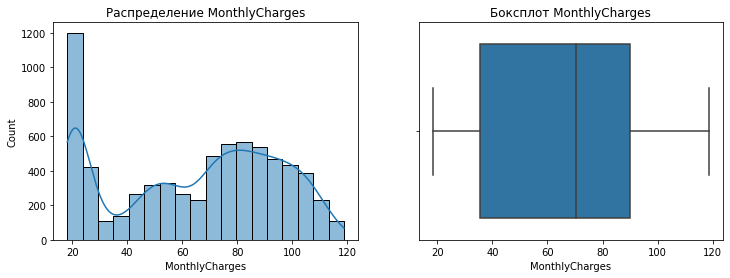

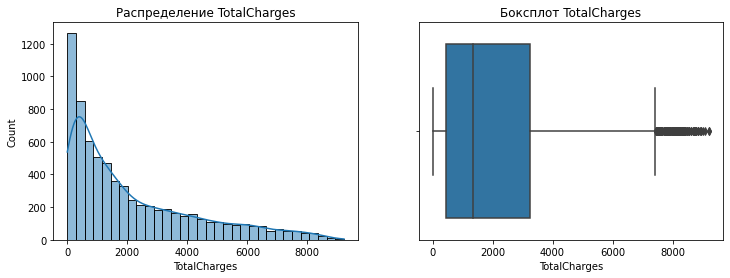

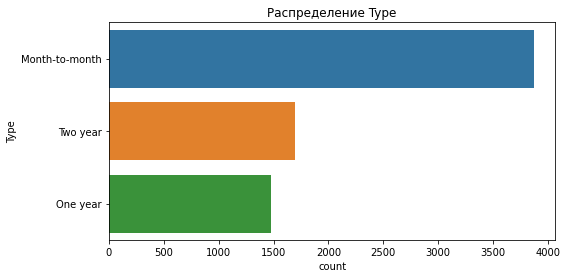

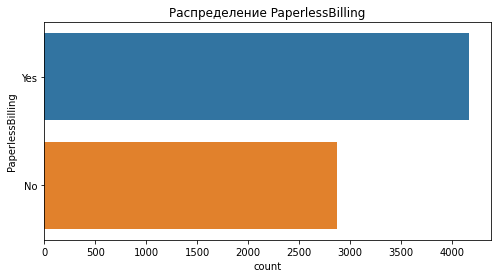

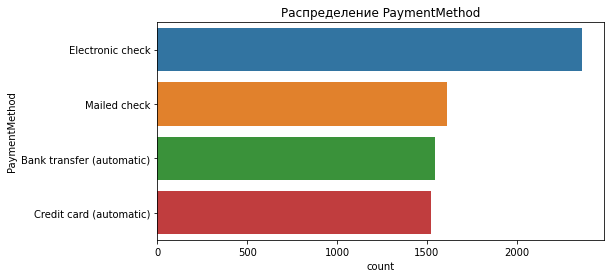

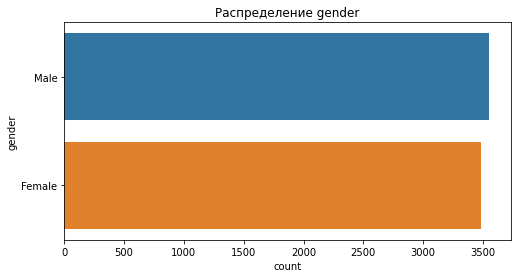

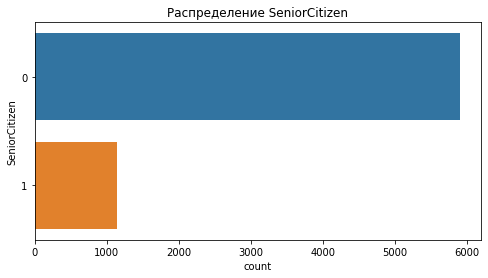

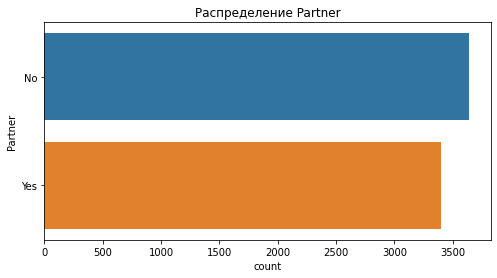

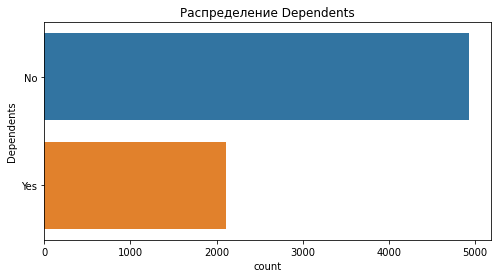

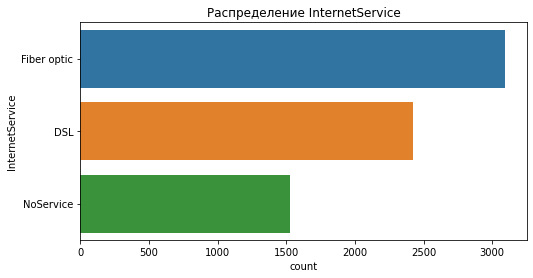

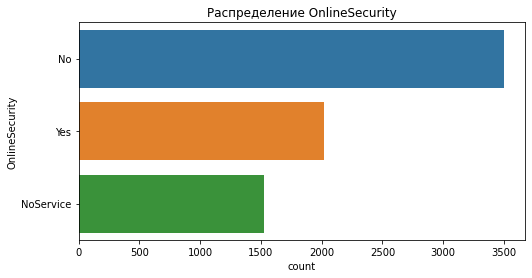

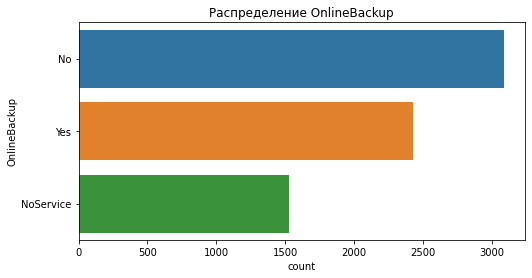

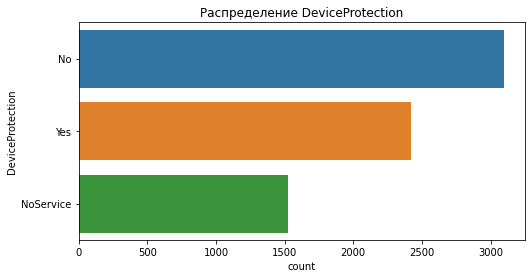

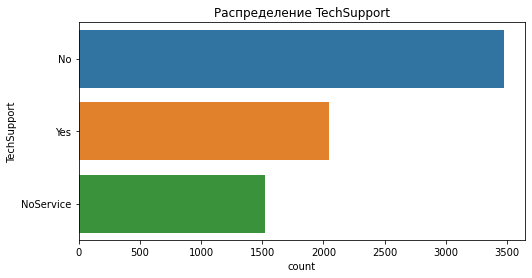

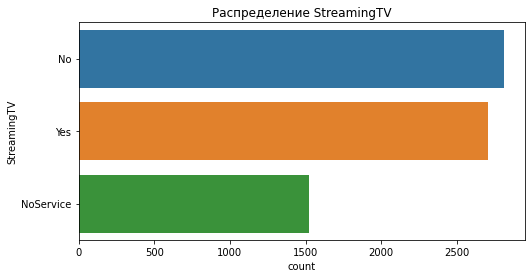

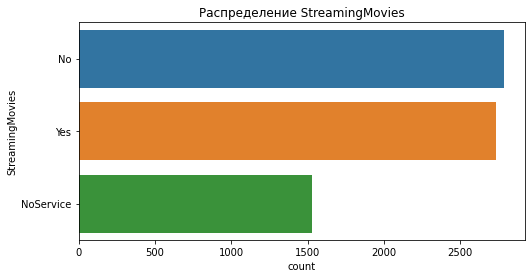

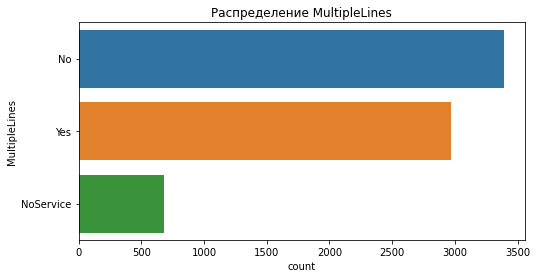

Количество выбросов по признакам:
{'MonthlyCharges': 0, 'TotalCharges': 195}


In [28]:
data_full_cat_cols = data_full.select_dtypes(include='object').drop(columns='customerID').columns.tolist()
data_full_num_cols = data_full.select_dtypes(include='number').columns.tolist()

describe_data(data_full[data_full_num_cols])
plot_distributions(data_full, data_full_num_cols)
plot_categorical_distribution(data_full, data_full_cat_cols)
check_outliers_iqr(data_full, data_full_num_cols)

**Описание и анализ признаков**

 - `MonthlyCharges` и `TotalCharges`: Оба признака имеют правостороннее распределение с концентрацией значений в нижних диапазонах (20–30 для MonthlyCharges, 0–5000 для TotalCharges) и редкими выбросами. Учитывая объединение данных (телефония без интернета или наоборот), это объясняет разнообразие в начислениях.
 
 - `ContractType`: Преобладает контракт "Month-to-month" (3500+ пользователей), указывая на предпочтение краткосрочных обязательств. "Two year" и "One year" (~1500) менее популярны, что отражает неготовность к долгосрочным связям.
 
 - `PaperlessBilling`: Безбумажный биллинг ("Yes", 4000+) опережает традиционный ("No", <3000), сигнализируя о переходе к цифровым методам.
 
 - `PaymentMethod`: Электронный чек (2000–2500) лидирует, за ним следуют "Mailed check", "Bank transfer (automatic)" и "Credit card (automatic)" (~1500) наименее популярен, возможно, из-за недоверия.
 
 - `Gender`: Мужчины и женщины представлены равномерно (по 3500), что указывает на сбалансированность по полу.
 
 - `SeniorCitizen`: Не пенсионеры ("No", 5000–6000) доминируют над пенсионерами ("Yes", ~1000), отражая преимущественно молодую или активную аудиторию.
 
 - `Partner`: Равное распределение между наличием и отсутствием партнера ~3500 не влияет на выбор услуг.
 
 - `Dependents`: Большинство (5000) не имеют иждивенцев ("No"), в то время как с иждивенцами ("Yes", ~2000) меньше, указывая на индивидуальное использование.
 
 - `InternetService`: "Fiber optic" (3000) лидирует, "DSL" (2500) на втором месте, а "No" (1500) показывает значительную долю пользователей без интернета, что связано с объединением данных.
 
 - `OnlineSecurity`: Преобладает отказ от услуги ("No", 5000) над использованием ("Yes", 2000), что может говорить о низком интересе.
 
 - `OnlineBackup`: Большинство (4500) не используют бэкап ("No"), а пользователей с услугой ("Yes", 2500) меньше, указывая на низкую популярность.
 
 - `DeviceProtection`: Аналогично, большинство (4500) без защиты ("No"), а с защитой ("Yes", 2500) — меньшинство, что не является приоритетом.
 
 - `TechSupport`: Большинство (5000) не пользуются поддержкой ("No"), а пользователей с ней ("Yes", 2000) меньше, подтверждая низкий спрос на допуслуги.
 
 - `StreamingTV`: Преобладает отказ от стриминга ТВ ("No", 4000) над использованием ("Yes", ~2600), показывая умеренный интерес.
 
 - `StreamingMovies`: Аналогично, большинство (4000) не смотрит фильмы ("No"), а пользователей с услугой ("Yes", ~2600) меньше, что не делает это массовым выбором.
 
 - `MultipleLines`: Большинство (4000) без множественных линий ("No"), но значительная часть (2500) их использует ("Yes"), что указывает на ограниченную популярность.

Данные отражают предпочтение краткосрочных контрактов и цифрового биллинга, с равномерным распределением по полу и партнерскому статусу. Преобладание не пенсионеров и пользователей без иждивенцев указывает на индивидуальное использование. Низкий спрос на дополнительные услуги (безопасность, бэкап, поддержка, стриминг) может быть связан с недостаточной осведомленностью или стоимостью. Объединение данных (телефония без интернета или наоборот) объясняет разнообразие в выборе интернет-услуг и начислениях.

### Feature engineering

На данном этапе были созданы новые признаки, обогащающие исходные данные и способствующие повышению информативности модели.

**Признак длительности договора (ContractDuration)**

Для оценки продолжительности обслуживания клиента был сформирован числовой признак `ContractDuration`, рассчитанный как разница между датой окончания и начала договора. Поскольку информация о клиентах актуальна на 1 февраля 2020 года, для клиентов с активным договором (у которых `EndDate` отсутствует) было подставлено значение 2020-02-01. Это позволило корректно рассчитать длительность для всех клиентов.

In [29]:
reference_date = pd.Timestamp('2020-02-01')

data_full['EndDate_filled'] = data_full['EndDate'].fillna(reference_date)

data_full['ContractDuration'] = (data_full['EndDate_filled'] - data_full['BeginDate']).dt.days

data_full[['BeginDate', 'EndDate_filled', 'ContractDuration']]

,BeginDate,EndDate_filled,ContractDuration
0,2020-01-01,2020-02-01,31
1,2017-04-01,2020-02-01,1036
2,2019-10-01,2020-02-01,123
3,2016-05-01,2020-02-01,1371
4,2019-09-01,2020-02-01,153
...,...,...,...
7038,2018-02-01,2020-02-01,730
7039,2014-02-01,2020-02-01,2191
7040,2019-03-01,2020-02-01,337
7041,2019-07-01,2020-02-01,215


In [30]:
data_full = data_full.drop(columns=['BeginDate', 'EndDate_filled'])

**Целевой признак (Churn)**

Целевой признак `Churn` отражает факт расторжения договора. Он сформирован на основе наличия даты завершения обслуживания: если `EndDate` присутствует — клиент ушёл (Churn = 1), если отсутствует — договор активен (Churn = 0).

In [31]:
data_full['Churn'] = (data_full['EndDate'] <= reference_date).astype(int)

display(data_full[['EndDate', 'Churn']].head(20))

data_full = data_full.drop(columns=['EndDate'])

,EndDate,Churn
0,NaT,0
1,NaT,0
2,NaT,0
3,NaT,0
4,NaT,0
5,NaT,0
6,NaT,0
7,NaT,0
8,NaT,0
9,2017-05-01,1


### Корреляционный анализ

Для выявления взаимосвязей между признаками необходим корреляционный анализ с использованием библиотеки `phik`, которая позволяет учитывать как числовые, так и категориальные переменные. 

In [32]:
data_corr = data_full.drop(columns=['customerID'])

interval_cols = ['MonthlyCharges', 'TotalCharges', 'ContractDuration']

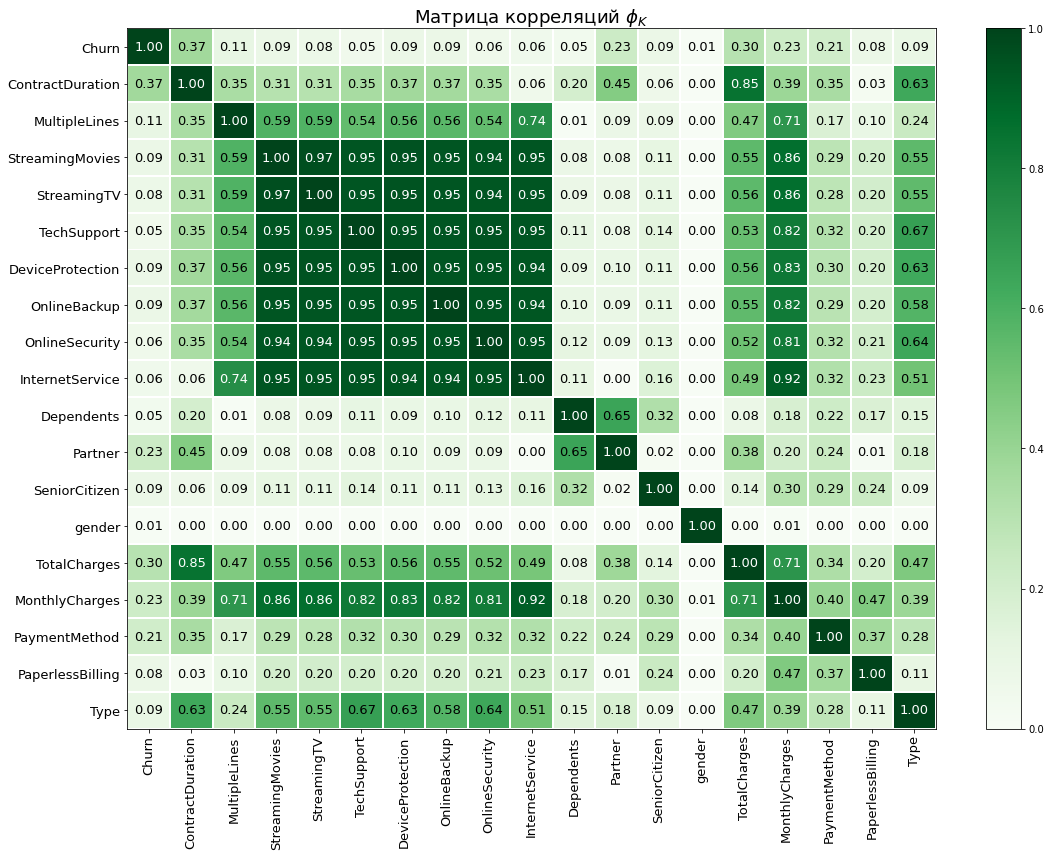

In [33]:
phik_overview = phik_matrix(data_corr, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Матрица корреляций $\phi_K$',
    fontsize_factor=1.3,
    figsize=(16, 12)
)

Корреляционный анализ позволил выявить ключевые взаимосвязи между признаками.

**Сильная корреляция (≥ 0.75)**
 - `StreamingMovies` и `StreamingTV` (0.95–0.97) – логично, оба связаны с доступом к потоковым сервисам.

 - `TechSupport`, `DeviceProtection`, `OnlineBackup`, `OnlineSecurity` между собой – корреляция 0.94–0.95. Все эти признаки отражают дополнительные услуги провайдера.

 - `MonthlyCharges` и `InternetService` (0.92) – очевидно, так как интернет влияет на ежемесячную плату.

 - `TotalCharges` и `ContractDuration` (0.85) – длительность контракта напрямую влияет на сумму выплат.

 - `StreamingMovies` и `MonthlyCharges` (0.86) и аналогично для StreamingTV (0.86).

 - `TotalCharges` и Online-сервисы (0.82–0.83) – чем больше услуг, тем выше итоговая сумма.

**Умеренная корреляция (≈ 0.4–0.75)**
 - `Churn` и `ContractDuration` (0.37) – чем длиннее контракт, тем меньше вероятность оттока.

 - `Churn` и `Partner` (0.23) – наличие партнёра снижает отток.

 - `MultipleLines` и `MonthlyCharges` (0.71) – логично: больше услуг → выше плата.

 - `PaperlessBilling` и `ContractDuration` (0.63) – возможно, бумажный биллинг больше у клиентов с долгим стажем.

 - `Type` и `DeviceProtection/TechSupport/Streaming...` (0.55–0.67) – возможно, тип клиента отражает набор услуг.

**Слабая корреляция ( ≤ 0.3)**
 - `Churn` ↔ большинство признаков (например, `gender`, `SeniorCitizen`, `Dependents`) – влияние этих признаков на отток слабое.

 - `Gender` ↔ любые признаки (все значения ≈ 0.00–0.01) – не влияет.

 - `SeniorCitizen` ↔ другие признаки (низкая корреляция, < 0.2) – слабое влияние.
 
 
**Мультиколлениарность**

Многие сервисы, которые предоставляет компания (например, потоковое видео, онлайн-бэкапы, защита устройств и т.п.), оказываются очень тесно связаны друг с другом. Это значит, что если клиент пользуется одним сервисом, он почти наверняка пользуется и другими.
В таблице это выражается высокой корреляцией между признаками — они "дублируют" друг друга.

Чтобы решить данную проблему, создадим поле `HasInternet`, которое будет отражать в целом подлкючение интернета, а также поле `NumberOfInternetServices`, которое будет содержать количество подлюченных дополнительных интренет-услуг

In [34]:
internet_services = [
    'StreamingTV',
    'StreamingMovies',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'OnlineSecurity'
]

data_full['NumberOfInternetServices'] = data_full[internet_services].apply(
    lambda row: sum(val == 'Yes' for val in row), axis=1
)

data_full['HasInternet'] = data_full['InternetService'].apply(lambda x: 0 if x == 'NoService' else 1)

data_full = data_full.drop(columns=internet_services)

In [35]:
data_full['HasInternet'].value_counts()

1    5517
0    1526
Name: HasInternet, dtype: int64

In [36]:
data_full

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,MultipleLines,ContractDuration,Churn,NumberOfInternetServices,HasInternet
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,NoService,31,0,1,1
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,No,1036,0,2,1
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,No,123,0,2,1
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,NoService,1371,0,3,1
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,153,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,One year,Yes,Mailed check,84.80,2035.20,Male,0,Yes,Yes,DSL,Yes,730,0,5,1
7039,2234-XADUH,One year,Yes,Credit card (automatic),103.20,7430.40,Female,0,Yes,Yes,Fiber optic,Yes,2191,0,4,1
7040,4801-JZAZL,Month-to-month,Yes,Electronic check,29.60,325.60,Female,0,Yes,Yes,DSL,NoService,337,0,1,1
7041,8361-LTMKD,Month-to-month,Yes,Mailed check,74.40,520.80,Male,1,Yes,No,Fiber optic,Yes,215,0,0,1


### Отбор признаков

In [37]:
cols_to_drop = ['gender', 'SeniorCitizen', 'Dependents', 'Partner']

data_full = data_full.drop(columns=cols_to_drop)

data_full.columns

Index(['customerID', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'InternetService', 'MultipleLines',
       'ContractDuration', 'Churn', 'NumberOfInternetServices', 'HasInternet'],
      dtype='object')

### Оценка дисбаланса классов

На данном этапе проводится анализ распределения целевой переменной — оттока клиентов `Churn`. Важно понять, насколько классы сбалансированы, так как сильный дисбаланс может негативно сказаться на качестве построенной модели.

In [38]:
class_counts = data_full['Churn'].value_counts()
class_percent = data_full['Churn'].value_counts(normalize=True) * 100

print("Распределение классов целевой переменной Churn:")
print(pd.DataFrame({'Количество': class_counts, 'Процентное соотношение (%)': class_percent}))

Распределение классов целевой переменной Churn:
   Количество  Процентное соотношение (%)
0        5942                   84.367457
1        1101                   15.632543


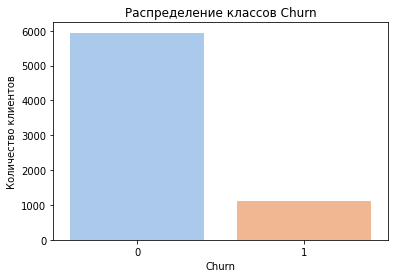

In [39]:
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='pastel')

plt.title('Распределение классов Churn')
plt.xlabel('Churn')
plt.ylabel('Количество клиентов')
plt.show()

Распределение классов целевой переменной `Churn` показывает, что большинство клиентов (около 84%) остаются с компанией , в то время как только около 16% клиентов уходят. 

### Промежуточный вывод

На этапе предобработки данных и исследовательского анализа были выполнены ключевые шаги, необходимые для подготовки данных к дальнейшему построению моделей машинного обучения:

**Проверка пропущенных значений**
 
После объединения данных пропуски обнаружены только в поле с датой окончания договора `EndDate`. Это логично, так как отсутствие даты означает, что договор ещё активен и клиент пользуется услугами. Пропуски не требуют удаления или замены и отражают текущих клиентов.

**Проверка на дубликаты**
 
В объединённом датасете отсутствуют дублирующиеся записи по идентификатору клиента, что подтверждает уникальность каждой записи.

**Анализ распределений признаков**
 
Анализ количественных и категориальных признаков показал:

 - Основные числовые признаки имеют характерное правостороннее распределение с редкими выбросами.

 - Среди контрактов преобладают краткосрочные ("Month-to-month").

 - Безбумажный биллинг более распространён, чем традиционный.

 - Мужчины и женщины представлены примерно поровну.

 - Пенсионеров меньше, чем активных клиентов.

 - Большинство клиентов не имеют партнёров и иждивенцев.

 - Среди интернет-услуг лидирует "Fiber optic", но значительная часть клиентов не пользуется интернетом.

 - Дополнительные услуги, такие как онлайн-защита, резервное копирование, техподдержка и стриминг, не пользуются широкой популярностью.


**Feature engineering**
 
Добавлен признак длительности контракта `ContractDuration`, рассчитанный как разница между датой окончания и началом договора. Для активных клиентов без даты окончания взята условная дата отсечки.
Также сформирован целевой признак `Churn`, указывающий на факт расторжения договора.

**Корреляционный анализ**
 
Выявлены сильные взаимосвязи:

 - Отток (Churn) коррелирует с длительностью контракта и ежемесячными платежами.

 - Общие и ежемесячные начисления связаны напрямую.

 - Тип контракта влияет на его длительность.

 - Демографические признаки практически не влияют на отток. 

**Отбор признаков**
 
Удалены признаки с низкой корреляцией с целевой переменной и потенциально избыточные: пол, наличие партнёра и иждивенцев, а также дата начала и окончания договора (последняя — из-за утечки данных).

**Оценка дисбаланса классов**
 
Целевая переменная `Churn` сильно несбалансирована: около 84% клиентов остаются, 16% уходят. 

<a id="section5"></a> 
## Подготовка данных

### Разделение датасета

Для оценки качества модели и предотвращения переобучения весь доступный датасет делится на обучающую и тестовую выборки в соотношении 3:1. Это означает, что 75% данных будут использованы для обучения модели, а оставшиеся 25% — для тестирования.
Такой подход обеспечивает достаточное количество данных как для обучения, так и для объективной оценки точности модели на ранее не встречавшихся примерах.

In [40]:
X = data_full.drop(['customerID', 'Churn'], axis=1)
y = data_full['Churn']


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

In [41]:
print("Размер X_train:", X_train.shape)
print("Размер X_test:", X_test.shape)
print("Размер y_train:", y_train.shape)
print("Размер y_test:", y_test.shape)

Размер X_train: (5282, 10)
Размер X_test: (1761, 10)
Размер y_train: (5282,)
Размер y_test: (1761,)


Данные корректно разделены на обучающую и тестовую выборки.

### Отбор признаков

Из набора данных отобраны только те признаки, которые могут реально влиять на поведение клиента. Неинформативные столбцы, такие как уникальный идентификатор клиента (customerID), были удалены.

Выделены следующие группы признаков:

 - Категориальные признаки (преобразуются методом One-Hot Encoding для регрессии, OrdinalEncoder для дерева и бустинга): тип подключения, способ оплаты, наличие дополнительных услуг. Эти признаки описывают характер взаимодействия клиента с компанией.

 - Числовые признаки: ежемесячные и суммарные расходы клиента, а также длительность контракта. Эти параметры напрямую отражают поведение клиента и его лояльность.

In [42]:
cat_columns = [ 
    'Type', 
    'PaperlessBilling', 
    'PaymentMethod', 
    'InternetService', 
    'MultipleLines'
]

num_columns = [
    'MonthlyCharges',
    'TotalCharges',
    'ContractDuration',
    'NumberOfInternetServices', 
    'HasInternet'
]

### Выбор моделей

В рамках проекта по прогнозированию оттока клиентов для построения и оценки качества моделей машинного обучения выбраны три различных алгоритма. Это обеспечивает разнообразие подходов к анализу данных и позволяет выбрать наиболее эффективную модель для решения задачи.

Выбранные модели:

 - `Логистическая регрессия` — простая и интерпретируемая линейная модель, хорошо подходящая для базового сравнения и анализа влияния отдельных признаков на вероятность оттока.

 - `Дерево решений` — модель на основе последовательного деления данных по признакам. Обеспечивает наглядную интерпретацию структуры принятия решений и позволяет выявить ключевые факторы, влияющие на отток.

 - `CatBoost` — современный градиентный бустинг на деревьях решений, оптимизированный для работы с категориальными признаками. CatBoost показывает высокую точность на реальных данных и устойчив к переобучению.


### Выбор метрики

Для более точной оценки качества моделей в условиях дисбаланса классов используется метрика `ROC AUC`. Она отражает способность модели корректно различать классы на различных порогах вероятности и лучше подходит для задач с несбалансированными данными.

In [43]:
roc_auc = make_scorer(roc_auc_score, needs_proba=True)

### Кодирование признаков

Для подготовки данных к обучению моделей  разработаны пайплайны, которые автоматически обрабатывают данные перед подачей на вход модели.

Для категориальных признаков реализован пайплайн, который заполняет отсутствующие значения наиболее частыми значениями и преобразует категории в числовой формат с помощью кодирования (one-hot / ordinal encoding). Это позволяет модели корректно работать с категориальными данными.

Для числовых признаков реализован отдельный пайплайн, который заменяет пропуски на медианные значения и масштабирует данные, приводя их к единому диапазону. Масштабирование помогает улучшить качество обучения и стабильность работы моделей.

In [44]:
ohe_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

ordinal_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', 'passthrough')  
])

data_preprocessor_logreg = ColumnTransformer([
    ('cat', ohe_pipe, cat_columns),
    ('num', num_pipe, num_columns)
])


data_preprocessor_tree_cb = ColumnTransformer([
    ('cat', ordinal_pipe, cat_columns),
    ('num', num_pipe, num_columns)
])

### Подбор гиперпараметров 

Для повышения точности моделей и оценки их устойчивости проводится подбор гиперпараметров с помощью метода GridSearchCV, который сочетает поиск лучших параметров с кросс-валидацией. Это позволяет объективно оценить качество модели на разных подвыборках обучающей выборки и избежать переобучения.

Используется 5-кратная кросс-валидация (cv=5). В процессе подбираются параметры моделей и способ масштабирования числовых признаков.

В нашем датасете наблюдается выраженный дисбаланс классов: около 85% клиентов не ушли и только 15% — ушли. 

In [45]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor_logreg),  
    ('model', LogisticRegression())
])

param_grid = [
    {
        'preprocessor': [data_preprocessor_logreg],
        'model': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'model__C': np.arange(0.1, 2.0, 0.3),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'preprocessor': [data_preprocessor_tree_cb],
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': range(2, 6),
        'model__max_features': [1, 2, 3, 'sqrt', 'log2'],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'preprocessor': [data_preprocessor_tree_cb],
        'model': [CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)],
        'model__depth': [4, 6, 8],
        'model__learning_rate': [0.01, 0.05, 0.1]
    }
]

grid_search = GridSearchCV(
    estimator=pipe_final,
    param_grid=param_grid,
    cv=5,
    scoring=roc_auc,
    n_jobs=-1,
)

### Промежуточный вывод

На данном этапе проекта выполнена полная подготовка данных для моделирования: проведено разбиение выборки, отбор значимых признаков, разработаны пайплайны для автоматической обработки данных и выполнен подбор гиперпараметров.

Выбраны три различные модели машинного обучения, что позволяет оценить эффективность разных подходов к прогнозированию оттока клиентов. Такой подход обеспечивает гибкость, устойчивость решений и позволяет выбрать модель с наилучшей производительностью.

Следующим шагом будет обучение моделей, их оценка по ключевым метрикам и выбор финального решения.

<a id="section6"></a> 
## Обучение моделей машинного обучения

### Обучение

На этом этапе проводится обучение трёх моделей машинного обучения с предварительно подобранными гиперпараметрами. Обучение осуществляется в рамках кросс-валидации, что позволяет оценить устойчивость моделей к случайным колебаниям в данных и выбрать наилучшую по метрике `ROC_AUC`, которая учитывает вероятность принадлежности к положительному классу (отток клиента).

In [46]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['Type',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod',
                                                                          'InternetService',
                                                                          'MultipleLines']),
                                                                        ('num',
                                                                         Pipeline(steps=[('impu...
                                                                                             OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                            unknown_value=-1))]),
                                                                            ['Type',
                                                                             'PaperlessBilling',
                                                                             'PaymentMethod',
                                                                             'InternetService',
                                                                             'MultipleLines']),
                                                                           ('num',
                                                                            Pipeline(steps=[('imputer',
                                                                                             SimpleImputer(strategy='median')),
                                                                                            ('scaler',
                                                                                             'passthrough')]),
                                                                            ['MonthlyCharges',
                                                                             'TotalCharges',
                                                                             'ContractDuration',
                                                                             'NumberOfInternetServices',
                                                                             'HasInternet'])])]}],
             scoring=make_scorer(roc_auc_score, needs_proba=True))

### Получение результатов обучения

После подбора гиперпараметров с помощью GridSearchCV получена лучшая модель, показавшая наилучшее значение метрики `ROC_AUC` при кросс-валидации.

In [47]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print('Лучшие параметры модели: ', grid_search.best_params_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Type', 'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'InternetService',
                                                   'MultipleLines']),
                                                 ('num',
                                               

Лучшая модель: `CatBoostClassifier` с `model__depth` = 4, `model__learning_rate` = 0.1.

Препроцессинг через `OrdinalEncoder`

Метрика `ROC_AUC` на обучающей выборке: **0.92** — высокая способность модели различать клиентов, склонных к оттоку.

### Промежуточный вывод

На этапе обучения были протестированы три модели машинного обучения с различными алгоритмами: логистическая регрессия, дерево решений и CatBoost. 

По результатам обучения лучшей оказалась модель `CatBoostClassifier` с параметрами:

 - depth = 4

 - learning_rate = 0.1

 - препроцессинг через `OrdinalEncoder`

Модель показала высокое качество классификации на обучающей выборке:

`ROC_AUC` = **0.92**

<a id="section7"></a> 
## Оценка лучшей модели

### Получение предсказаний на тестовой выборке

После выбора лучшей модели производится проверка её качества на тестовой выборке, которая не участвовала в обучении и подборе параметров. Это позволяет объективно оценить обобщающую способность модели на новых данных.

In [48]:
y_pred = grid_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_pred):.4f}')

Метрика ROC-AUC на тестовой выборке: 0.9026


Итоговая модель `CatBoostClassifier`, обученная с учётом дисбаланса классов и с подобранными гиперпараметрами показала высокую стабильность:

 - `ROC_AUC` на обучающей выборке: 0.92

 - `ROC_AUC` на тестовой выборке: 0.90

Это говорит о том, что модель не переобучена, сохраняет высокую способность к распознаванию клиентов, склонных к оттоку.

### Accuracy на тестовой выборке

Помимо метрики `ROC_AUC`, дополнительно оценим долю правильных предсказаний `accuracy` — то есть, сколько объектов модель классифицировала верно.

In [49]:
y_class_pred = grid_search.predict(X_test)
print(f'Accuracy на тестовой выборке: {accuracy_score(y_test, y_class_pred):.4f}')

Accuracy на тестовой выборке: 0.9290


Это означает, что модель правильно предсказала поведение клиентов в **93%** случаев

### Оценка выбранной модели на "адекватность"

Для оценки адекватности модели была обучена простейшая модель — `DummyClassifier`, которая всегда предсказывает наиболее частый класс. Это позволяет понять, насколько выбранная модель превосходит наивный подход.

In [50]:
dummy_model = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)

y_dummy_pred_proba = dummy_model.predict_proba(X_test)[:, 1]
y_dummy_pred = dummy_model.predict(X_test)

print(f'Метрика ROC_AUC DummyClassifier: {roc_auc_score(y_test, y_dummy_pred_proba):.4f}')
print(f'Метрика accuracy DummyClassifier: {accuracy_score(y_test, y_dummy_pred):.4f}')

Метрика ROC_AUC DummyClassifier: 0.5000
Метрика accuracy DummyClassifier: 0.8438


Модель `CatBoost` существенно превосходит наивную стратегию как по метрике `ROC_AUC`, так и по точности. Это подтверждает её обученность и практическую значимость.

### Анализ важности признаков

После обучения и оценки модели важно понять, какие признаки оказали наибольшее влияние на принятие решений моделью. Это позволяет не только повысить доверие к модели, но и выявить ключевые факторы, влияющие на отток клиентов.

Для этого был проведён анализ важности признаков с использованием метода `SHAP`. Он позволяет интерпретировать модель, показывая, как каждый признак влияет на вероятность оттока для конкретного клиента.

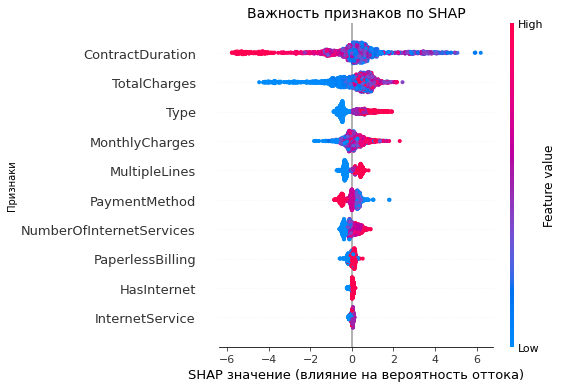

In [51]:
best_model = grid_search.best_estimator_
catboost_model = best_model.named_steps['model']
preprocessor = best_model.named_steps['preprocessor']

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

try:
    ohe_features = preprocessor.transformers_[0][1].named_steps['ohe'].get_feature_names_out(cat_columns)
    num_features_final = num_columns
    feature_names = list(ohe_features) + list(num_features_final)
except KeyError:
    feature_names = cat_columns + num_columns

explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_test_preprocessed)

plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values, 
    features=X_test_preprocessed, 
    feature_names=feature_names, 
    show=False
)
plt.title("Важность признаков по SHAP", fontsize=14)
plt.xlabel("SHAP значение (влияние на вероятность оттока)")
plt.ylabel("Признаки")
plt.tight_layout()
plt.show()

**Основные выводы:**
 - `ContractDuration`: Этот признак имеет наибольшее влияние на вероятность оттока. Чем дольше срок контракта, тем меньше вероятность оттока.

 - `TotalCharges`: высокие значения этого признака снижают вероятность оттока, а низкие значения увеличивают её.

 - `Type`: тип контракта также оказывает значительное влияние. Например, определённые типы контрактов могут быть связаны с более высокой вероятностью оттока.

 - `MonthlyCharges`: высокие ежемесячные платежи увеличивают вероятность оттока, а низкие платежи снижают её.

 - `MultipleLines`: наличие нескольких линий связи может снижать вероятность оттока, в то время как отсутствие увеличивает её.

 - `PaymentMethod`: метод оплаты также влияет на отток. Например, определённые методы могут быть связаны с более низкой вероятностью оттока.

 - `NumberOfInternetServices`: количество интернет-услуг влияет на вероятность оттока. Большее количество услуг (синие точки) снижает вероятность оттока.

 - `PaperlessBilling`: безбумажный биллинг может снижать вероятность оттока, а традиционный биллинг увеличивает её.

 - `HasInternet`: наличие интернета снижает вероятность оттока, а его отсутствие увеличивает её.

 - `InternetService`: тип интернет-услуги также влияет на отток. Например, определённые услуги могут быть связаны с более низкой вероятностью оттока.

### Анализ матрицы ошибок

Для дополнительной оценки качества модели был построен анализ матрицы ошибок. Этот инструмент позволяет увидеть, как именно модель классифицирует клиентов: кого она определяет верно, а где может ошибаться.

 - True Positive (TP) — модель правильно предсказала, что клиент уйдёт.

 - True Negative (TN) — модель правильно предсказала, что клиент останется.

 - False Positive (FP) — модель ошибочно посчитала, что клиент уйдёт (на самом деле остался).

 - False Negative (FN) — модель не предсказала отток, хотя клиент ушёл (самая критичная ошибка).

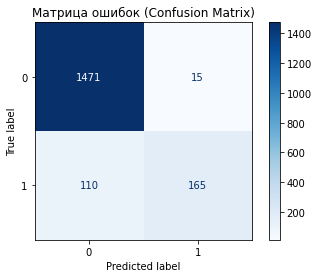

In [52]:
cm = confusion_matrix(y_test, y_class_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.named_steps['model'].classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Матрица ошибок (Confusion Matrix)')
plt.show()

**Интерпретация результатов:**
 - 1471 клиентов модель правильно определила как лояльных — они остались, и модель это предсказала.

 - 165 клиента модель правильно определила как тех, кто уйдёт — это самая важная группа для удержания.

 - 110 случая — клиенты ушли, но модель это не предсказала (ошибка 2-го рода). Это критичная ошибка, так как компания теряет клиента неожиданно.

 - 15 случай — модель ошибочно посчитала, что клиент уйдёт, но он остался. Эта ошибка менее опасна: она может привести к ненужным усилиям по удержанию, но не к прямым потерям.

In [53]:
print(classification_report(y_test, y_class_pred, target_names=['Остался', 'Ушёл']))

              precision    recall  f1-score   support

     Остался       0.93      0.99      0.96      1486
        Ушёл       0.92      0.60      0.73       275

    accuracy                           0.93      1761
   macro avg       0.92      0.79      0.84      1761
weighted avg       0.93      0.93      0.92      1761



Модель хорошо справляется с задачей классификации, особенно с учётом дисбаланса классов (85% остались, 15% ушли).

**Основные выводы**:

 - Модель отлично распознаёт клиентов, которые остаются `recall` = 0.99.

 - Для клиентов, которые уходят, модель работает с умеренной полнотой `recall` = 0.6, но с достаточно высокой точностью `precision` = 0.92.

 - Метрика `F1-score` для ушедших клиентов — 0.73 — показывает сбалансированную способность модели выявлять редкий, но важный класс.

### Промежуточный вывод

Проведённая оценка финальной модели `CatBoostClassifier`, обученной с учётом дисбаланса классов и подобранными гиперпараметрами, показала высокую эффективность и устойчивость к новым данным.

`ROC_AUC` на тесте составил **0.9**, что говорит о способности модели уверенно различать клиентов, склонных к оттоку, и лояльных.

Точность `accuracy` составила **93%**, что означает, что модель верно классифицировала поведение клиентов в большинстве случаев.

В сравнении с наивной моделью `DummyClassifier`, `ROC_AUC` = **0.500**, `Accuracy` = **84.4%** модель `CatBoost` показывает значительное улучшение качества.

Также был выполнен анализ важности признаков с использованием `SHAP`. Выявлены ключевые факторы, влияющие на отток:

 - Длительность контракта и тип подключения являются сильными предикторами лояльности.

 - Высокие ежемесячные платежи, использование электронных чеков и отсутствие дополнительных услуг — признаки, повышающие риск ухода.

Матрица ошибок подтвердила, что модель надежно определяет лояльных клиентов, но может допускать ошибки второго рода (не распознанный уход). Тем не менее, уровень таких ошибок является приемлемым для практического применения.

<a id="section8"></a> 
## Общий вывод

### Вывод по проекту

В ходе данного проекта была успешно реализована машинного обучения для прогнозирования оттока клиентов телекоммуникационной компании. Работа охватывала весь жизненный цикл ML-проекта — от первичной обработки данных до анализа результатов и разработки рекомендаций.

**Основные этапы проекта:**

 - Проведена тщательная предобработка данных: удалены неинформативные признаки, обработаны пропуски, категориальные признаки закодированы, числовые — масштабированы.

 - Сформирован pipeline обработки данных и обучения модели, что обеспечивает повторяемость и масштабируемость решений.

 - Проведён сравнительный анализ трёх моделей: логистической регрессии, дерева решений и градиентного бустинга (CatBoost).

 - В результате отбора гиперпараметров с использованием `GridSearchCV` лучшей признана модель `CatBoostClassifier`, которая:

   - демонстрирует высокую устойчивость и отличную обобщающую способность (`ROC-AUC` на тесте = **0.9**, `accuracy` = **93%**);

   - показывает существенное превосходство над наивной моделью (`DummyClassifier`: `ROC-AUC` = 0.50, `accuracy` = 84.4%).

 - Проведён `SHAP-анализ` важности признаков, позволяющий интерпретировать модель и обосновывать бизнес-решения.

 - Выполнен анализ ошибок классификации с помощью матрицы ошибок и отчёта по метрикам `(precision, recall, f1-score)`, выявлены слабые места модели (ошибки 2-ого рода).

Таким образом, модель готова к интеграции в производственные процессы и может использоваться для предсказания риска оттока клиентов с высокой точностью и интерпретируемостью.

### Рекомендации заказчику

**Рекомендации для бизнеса**

 - Сегментировать клиентов по вероятности оттока, используя разработанную модель. Для группы высокого риска запускать программы удержания.

 - Автоматизировать мониторинг ключевых факторов риска, выявленных моделью:

   - Контракты менее 1 года,

   - Нет дополнительных услуг,

   - Способ оплаты: электронный чек,

   - Высокий `MonthlyСharges` при низком `TotalCharges`.

 - Разработать меры лояльности:

   - Предлагать выгодные условия продления контракта на 1–2 года,

   - Кросс-продажи дополнительных услуг (техподдержка, резервное копирование и др.),

   - Персонализированные скидки или бонусы для клиентов с высоким риском ухода.

Регулярно переобучать модель на новых данных, чтобы сохранить её актуальность в условиях меняющегося поведения клиентов.